In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import transformers
import wandb

from dataloader import DataLoader
from evaluate import load
from trainer import CustomTrainer
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    DataCollatorWithPadding
)

In [14]:
torch.cuda.empty_cache()

In [15]:
# os.environ["WANDB_MODE"] = "disabled"  # Disable wandb logging
# os.environ["WANDB_DISABLED"] = "true"  # Fully disable wandb

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_name = "prajjwal1/bert-tiny"
dataset_name = "multi_nli"

data_loader = DataLoader(dataset_name, model_name)
train_dataset, eval_dataset, tokenizer, num_labels = data_loader.prepare_datasets()

Using device: cuda


In [16]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels  # MNLI has 3 classes: entailment, contradiction, neutral
)
model.to(device)

# Load accuracy metric
metric = load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

# Training arguments
training_args = TrainingArguments(
    output_dir="bert-tiny-mnli",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    logging_steps=500,
    logging_first_step=True,
)


wandb.init(
    project="bert_tiny_mnli",
    name=f"{training_args.num_train_epochs}_epochs_{dataset_name}_bert_tiny",
    config=training_args.to_dict(),
)

# Initialise trainer and train
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
    methods=["loss", "forgetting"]
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/hrm20/dlenv2/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


/vol/bitbucket/hrm20/fyp/trainer.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.828600,0.799980,0.648395
2,0.808300,0.781367,0.656852



Epoch 1 Summary:
Average Loss: 0.8932

Epoch 2 Summary:
Average Loss: 0.8119


TrainOutput(global_step=49088, training_loss=0.852666575415485, metrics={'train_runtime': 616.7451, 'train_samples_per_second': 1273.466, 'train_steps_per_second': 79.592, 'total_flos': 249539212336128.0, 'train_loss': 0.852666575415485, 'epoch': 2.0})

In [17]:
forgetting_results = trainer.get_unified_stats()['forgetting_stats']['forgetting_events']
forgetting_results

{0: 0,
 1: 1,
 2: 1,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 1,
 8: 0,
 9: -1,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 1,
 15: 0,
 16: 1,
 17: 0,
 18: 0,
 19: -1,
 20: 1,
 21: 0,
 22: 1,
 23: 0,
 24: 0,
 25: 0,
 26: -1,
 27: 0,
 28: 1,
 29: 0,
 30: 1,
 31: 0,
 32: 0,
 33: 0,
 34: 1,
 35: 1,
 36: 1,
 37: 1,
 38: 0,
 39: 1,
 40: -1,
 41: 0,
 42: 1,
 43: 0,
 44: 0,
 45: 1,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: -1,
 51: 1,
 52: 1,
 53: 0,
 54: 0,
 55: 0,
 56: 0,
 57: 0,
 58: 0,
 59: 0,
 60: 0,
 61: 1,
 62: 0,
 63: -1,
 64: 1,
 65: 1,
 66: 0,
 67: 1,
 68: 0,
 69: 1,
 70: 0,
 71: 0,
 72: 1,
 73: 0,
 74: 0,
 75: 0,
 76: 0,
 77: 1,
 78: 0,
 79: 0,
 80: 1,
 81: 1,
 82: 0,
 83: 0,
 84: 0,
 85: 1,
 86: 0,
 87: 0,
 88: 0,
 89: -1,
 90: 1,
 91: 0,
 92: 0,
 93: 0,
 94: 0,
 95: -1,
 96: 0,
 97: 0,
 98: 0,
 99: 0,
 100: 0,
 101: 1,
 102: -1,
 103: -1,
 104: 0,
 105: 0,
 106: 0,
 107: 1,
 108: 1,
 109: 0,
 110: -1,
 111: -1,
 112: 0,
 113: 1,
 114: 0,
 115: 0,
 116: 0,
 117: 0,
 118: 0,
 119: 0,
 120: 0,
 121: 0,


In [18]:
loss = trainer.get_unified_stats()['loss_stats']['epoch_losses']
epoch_losses = loss

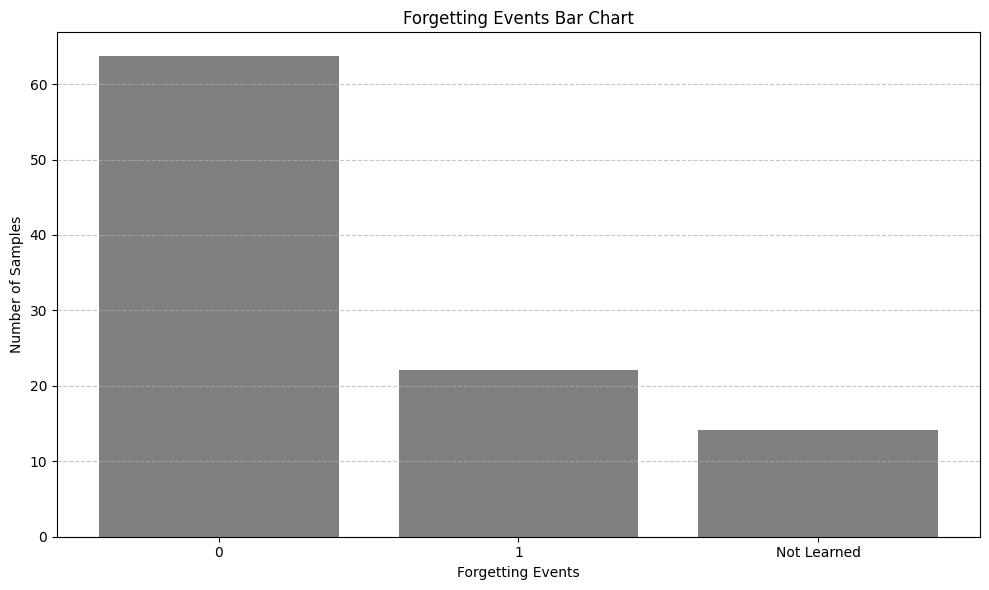

In [19]:
# Count freqs of forgetting events
forgetting_counts = {}
for value in forgetting_results.values():
    if value not in forgetting_counts:
        forgetting_counts[value] = 0
    forgetting_counts[value] += 1

# Separate not-learned from other labels
forgetting_keys = sorted([k for k in forgetting_counts.keys() if k != -1])
forgetting_labels = forgetting_keys + ["Not Learned"]

total_samples = len(train_dataset)

# Calculate percentages
forgetting_values = [forgetting_counts[k] / total_samples * 100 for k in forgetting_keys]
forgetting_values.append(forgetting_counts[-1] / total_samples * 100)

# Plot chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(forgetting_labels)), forgetting_values, color='gray')

plt.xticks(range(len(forgetting_labels)), forgetting_labels)
plt.xlabel("Forgetting Events")
plt.ylabel("Number of Samples")
plt.title("Forgetting Events Bar Chart")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig("forgetting_events.png")
wandb.log({"Forgetting Events Chart": wandb.Image("forgetting_events.png")})

plt.tight_layout()
plt.show()


In [20]:
print(forgetting_counts)

{0: 250077, 1: 86890, -1: 55735}


In [21]:
trainer.get_unified_stats()['loss_stats']['per_sample_average_losses']

{0: 0.7716023822625478,
 1: 1.802868624528249,
 2: 0.9970445930957794,
 3: 1.015384075542291,
 4: 0.6655147771040598,
 5: 1.0629159212112427,
 6: 1.0879541635513306,
 7: 1.0072308381398518,
 8: 0.5813619196414948,
 9: 1.4599850972493489,
 10: 0.5833285252253214,
 11: 0.761757512887319,
 12: 0.6428020497163137,
 13: 0.8441917399565378,
 14: 1.0614256858825684,
 15: 0.8661131262779236,
 16: 1.1115411619345348,
 17: 0.6260696748892466,
 18: 1.3208511074384053,
 19: 1.058412233988444,
 20: 1.1555657088756561,
 21: 0.5612900877992312,
 22: 0.6524194031953812,
 23: 0.613873265683651,
 24: 0.897514820098877,
 25: 0.6682738562424978,
 26: 1.0718133052190144,
 27: 0.9316790898640951,
 28: 1.044945478439331,
 29: 0.6152217288812002,
 30: 1.6936346689860027,
 31: 1.2502827445665996,
 32: 0.7480419973532358,
 33: 0.49999817709128064,
 34: 1.3348998228708904,
 35: 1.4632868766784668,
 36: 0.8444050351778666,
 37: 0.8362176467974981,
 38: 0.7030007441838583,
 39: 1.496547708908717,
 40: 1.3074102799

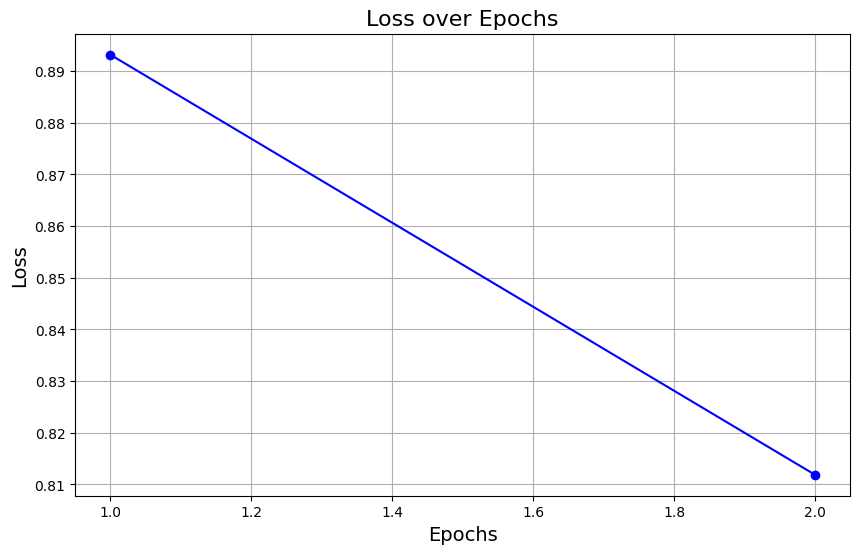

[0.8931639240488646, 0.8118891262730353]


In [22]:
# Plot the average loss per epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linestyle='-', color='b')

plt.title("Loss over Epochs", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)

plt.savefig("loss_over_epochs.png")
wandb.log({"Loss over Epochs": wandb.Image("loss_over_epochs.png")})
plt.show()
print(epoch_losses)

In [23]:
wandb.log({
    "final_train_loss": epoch_losses[-1],
    "final_forgetting_stats": forgetting_results
})

In [24]:
 wandb.finish()

eval/accuracy,▁█
eval/loss,█▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
final_train_loss,▁
train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
train/grad_norm,▁▂▅▅▃▅▅▅▅▆▅▅▆▅▅▅▆▅▅▅▄▅▆▅▅▆▇▆▆▆▇▆▄▅▅▆█▆▇▅
train/learning_rate,██▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,█▆▆▅▅▄▄▄▄▄▃▄▃▃▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▂
